In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
import xml.etree.ElementTree as et 
from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'

In [3]:
def peek(df):
    display(df.iloc[:3])
    print(len(df))
    
def hash_station_id(station_id):
    try:
        float_id = float(station_id)
        int_id = int(float(station_id))
        if int_id == float_id:
            return str(int_id)
        else:
            return str(float_id)
    except:
        return str(station_id)

In [4]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [5]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    return edges_gdf

## Create Bike Lane Network

In [30]:
LANES_DATE_STRING = '202101'
DATE_STRING = '202110'

In [7]:
lanes_mg = nx.read_shp(f'{DATA_DIR}/geo/lanes/' +
                       f'{LANES_DATE_STRING}_lanes_citibike_area.shp')
lanes_mg.graph['crs'] = CRS_LATLON

# Select only the largest weakly connected component.
lanes_wcc = max(nx.weakly_connected_components(lanes_mg), key=len)
lanes_mg = lanes_mg.subgraph(lanes_wcc)

# Remove directionality due to incorrect infeasible paths!j
lanes_g = nx.Graph(lanes_mg)

In [8]:
node_gdf = graph_to_node_gdf(lanes_g)
edge_gdf = graph_to_edge_gdf(lanes_g)

In [9]:
# Add edge length as attribute.
attrs = {}
for edge in edge_gdf.iterrows():
    k, v = (edge[0][0], edge[0][1]), (edge[0][2], edge[0][3])
    attrs = lanes_g.get_edge_data(k, v)
    attrs['length'] = edge[1]['length']

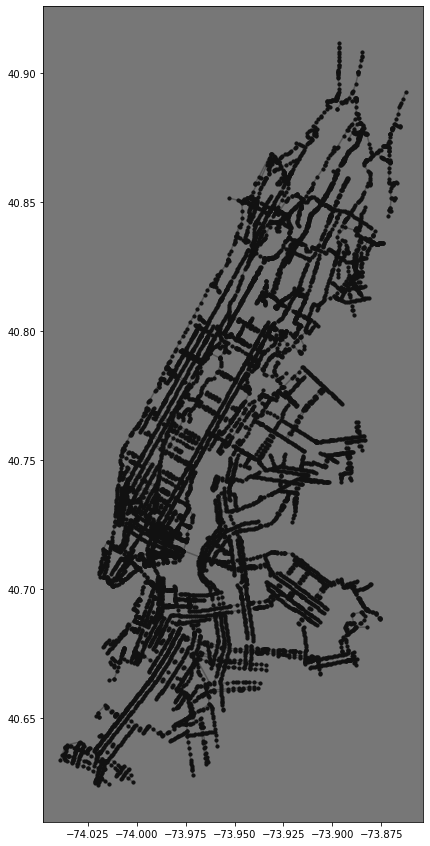

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=10, color='#111', zorder=2)
ax.set_facecolor('#777')

## Identify Citi Bike Stations Near Network

In [11]:
stations_df = pd.read_csv(f'{EXPORTS_DIR}/station_coords.csv')
stations_df['date'] = stations_df['date'].astype(str)

nyc_gdf = gpd.read_file(f'{DATA_DIR}/geo/census_tract/nyc_ct.shp')
nyc_gdf = nyc_gdf[['ct2010', 'boro_code', 'geometry']]

def clean_stations_df(stations_gdf):
    """Filters stations to only those within NYC Citi Bike Service Area."""
    gdf = gpd.sjoin(stations_gdf, nyc_gdf, how='inner', op='within')
    gdf = gdf.drop(columns=['index_right'])
    return gdf


def get_stations_for_date(date_string):
    """Returns a dataframe with the most recent station positions prior to the
    given YYYYMM date string."""
    
    # Select all stations prior to the given date string.
    stations_before_df = stations_df[stations_df['date'] < date_string]
    # Select the most recent of those stations.
    stations_recent_df = stations_before_df.groupby(
        by=['id']).last().reset_index()

    # Only select stations with at least one trip leaving or entering..
    adf = pd.read_csv(
        f'{DATA_DIR}/citibike/exports/adjacency_matrices/' +
        f'{date_string}_trip_count.csv'
    )
    adf = adf.set_index(adf.columns[0])
    adf.index.name = None
    adf = adf.iloc[:, 1:]
    adf.index = [hash_station_id(i) for i in adf.index]
    adf.columns = [hash_station_id(i) for i in adf.columns]
    stations_set = set(list(adf.index) + list(adf.columns))
    stations_nonzero_df = stations_recent_df[stations_recent_df['id'].isin(
        stations_set)]

    return stations_nonzero_df


def get_stations_gdf_for_date(date_string):
    df = get_stations_for_date(date_string)
    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df['lon'], df['lat']),
                           crs=CRS_LATLON)
    display(gdf)
    gdf = clean_stations_df(gdf)
    return gdf

In [31]:
stations_gdf = get_stations_gdf_for_date(DATE_STRING)

,id,date,lat,lon,geometry
81,2733.03,202103,40.633385,-74.016562,POINT (-74.01656 40.63338)
86,2782.02,202103,40.635679,-74.020005,POINT (-74.02000 40.63568)
91,2832.03,202103,40.637033,-74.022141,POINT (-74.02214 40.63703)
94,2872.02,202103,40.637660,-74.017820,POINT (-74.01782 40.63766)
95,2883.03,202103,40.638246,-74.024714,POINT (-74.02471 40.63825)
...,...,...,...,...,...
3135,JC104,202102,40.719252,-74.034234,POINT (-74.03423 40.71925)
3137,JC106,202105,40.716870,-74.032810,POINT (-74.03281 40.71687)
3142,SYS032,202102,40.703276,-73.931835,POINT (-73.93184 40.70328)
3143,SYS033,202102,40.728487,-74.011693,POINT (-74.01169 40.72849)


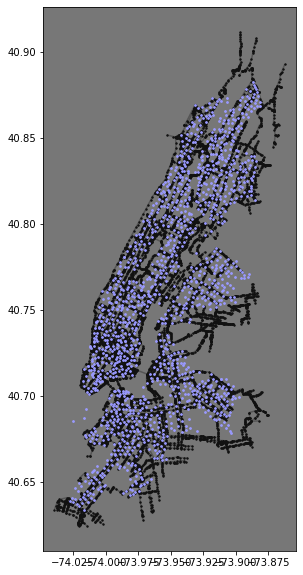

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=2, color='#111', zorder=2)
stations_gdf.plot(ax=ax, markersize=3, color='#99f', zorder=3)
ax.set_facecolor('#777')

In [33]:
def closest_node(station, nodes):
    """Returns the closest node of the given nodes to the given station."""
    min_node = None
    min_dist = 100
    for node in nodes:
        dist = station.distance(node)
        if dist < min_dist:
            min_dist = dist
            min_node = node
    return ((min_node.x, min_node.y), min_dist)

In [34]:
# Requires a Citi Bike station to be within 0.001 degrees of a node in order to
# select it.
STATION_THRESHOLD = 0.001

nodes = list(node_gdf['geometry'])
stations = list(stations_gdf['geometry'])

# Create a dictionary of stations within STATION_THRESHOLD degrees of a node.
prox_dict = {
    (station.x, station.y): closest_node(station, nodes) for station in stations
}
prox_dict = {k: v for k, v in prox_dict.items() if v[1] < 0.001}

In [35]:
prox_station_geoms = [Point(k) for k in prox_dict.keys()]

stations_gdf = stations_gdf[stations_gdf.geometry.isin(prox_station_geoms)]
stations_gdf['node'] = stations_gdf.geometry.apply(lambda g: prox_dict[(g.x, g.y)][0])
stations_gdf = stations_gdf.set_index('id')

In [36]:
station_nodes_gdf = node_gdf.merge(stations_gdf[['node']], left_index=True, right_on='node', how='inner')

### Restrict to Active Citi Bike Stations

In [37]:
am_df = pd.read_csv(f'{DATA_DIR}/citibike/exports/adjacency_matrices/{DATE_STRING}_trip_count.csv')
am_df = am_df.set_index(am_df.columns[0])
am_df.index.name = None
am_df = am_df.iloc[:, 1:]
am_df.index = [hash_station_id(i) for i in am_df.index]
am_df = am_df[am_df.index.isin(station_nodes_gdf.index)]
am_df = am_df[(c for c in am_df.columns if c in am_df.index)]
am_df = am_df.loc[list(am_df.columns), :]
peek(am_df)

,2782.02,2832.03,2872.02,2883.03,2923.01,2932.01,2951.05,2961.05,3007.05,3011.03,...,8752.01,8766.03,8778.01,8782.01,8795.01,8795.03,8799.01,8811.01,8841.03,SYS033
2782.02,27,9,6,3,0,4,3,11,0,1,...,0,0,0,0,0,0,0,0,0,0
2832.03,6,29,1,10,8,23,5,4,2,28,...,0,0,0,0,0,0,0,0,0,0
2872.02,7,2,8,2,2,1,4,7,1,7,...,0,0,0,0,0,0,0,0,0,0


998


In [38]:
station_nodes_gdf = station_nodes_gdf.merge(am_df, how='inner', left_index=True, right_index=True)[station_nodes_gdf.columns]

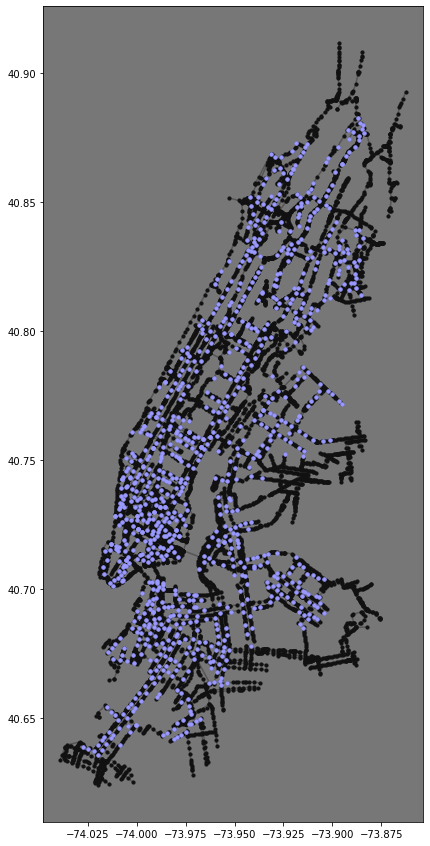

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=10, color='#111', zorder=2)
station_nodes_gdf.plot(ax=ax, markersize=12, color='#99f', zorder=3)
ax.set_facecolor('#777')

## Find Shortest Paths for O-D Pairs for Single Origin

In [40]:
def path_to_edge_list(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]

In [41]:
def path_to_edge_gdf(G, edges):
    geom = [LineString((Point(edge[0][0], edge[0][1]), Point(edge[1][0], edge[1][1]))) for edge in edges]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame({}, index=edge_index, crs=CRS_LATLON, geometry=list(geom))
    return edges_gdf

In [42]:
def get_edge_key(gdf, edge):
    key1 = (
        edge[0][0],
        edge[0][1],
        edge[1][0],
        edge[1][1],
    )
    key2 = (
        edge[1][0],
        edge[1][1],
        edge[0][0],
        edge[0][1],
    )
    return key1 if key1 in gdf.index else key2

In [43]:
# Only consider O-D pairs with a minimum number of trips.
TRIP_THRESHOLD = 3

def get_destination_ids(orig_id, trip_threshold=TRIP_THRESHOLD):
    dest_ids = am_df[am_df[orig_id] >= trip_threshold][orig_id]
    return list(dest_ids.index)

In [44]:
def get_station_node(station_id):
    return station_nodes_gdf.loc[station_id, 'node']

In [45]:
# Choose an example origin near the east side of the Wiliamsburg Bridge.
orig_id = '5117.05'
dest_ids = get_destination_ids(orig_id, trip_threshold=5)

In [46]:
orig_node = get_station_node(orig_id)
dest_ids = get_destination_ids(orig_id)
dest_nodes = [get_station_node(dest_id) for dest_id in dest_ids]
path_gdfs = []

for dest_node in dest_nodes:
    path = nx.shortest_path(lanes_g, orig_node, dest_node, weight='length')
    edge_list = path_to_edge_list(path)
    path_gdfs.append(path_to_edge_gdf(lanes_g, edge_list))

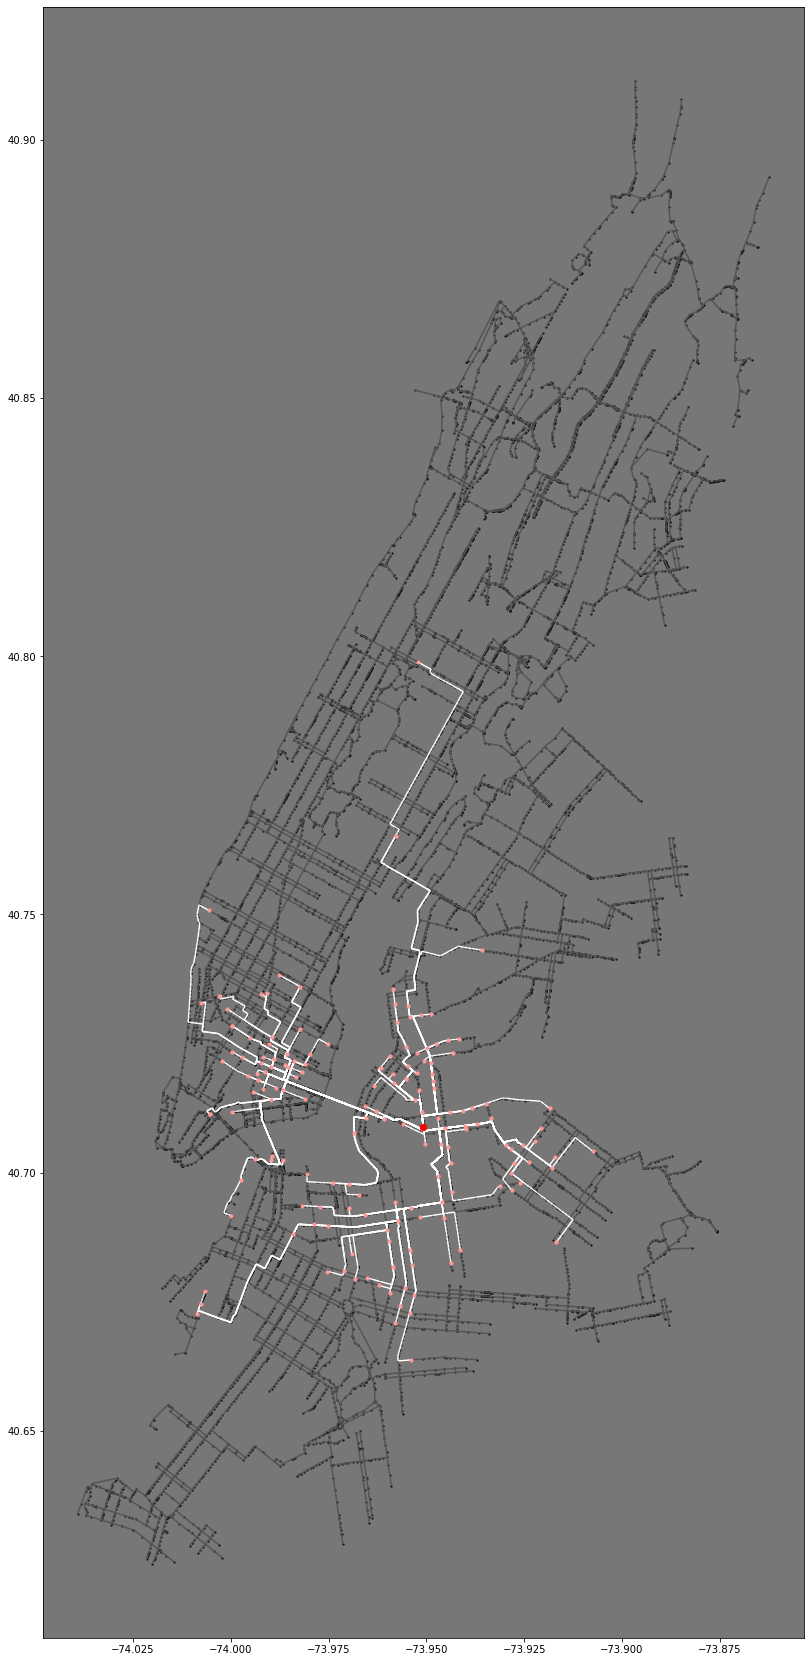

In [47]:
fig, ax = plt.subplots(figsize=(30, 30))
node_gdf.plot(ax=ax, markersize=1.5, color='#111', zorder=1)
edge_gdf.plot(ax=ax, color='#555', zorder=2)
for path_gdf in path_gdfs:
    path_gdf.plot(ax=ax, color='#fff', zorder=3)
dest_lats = [node[1] for node in dest_nodes]
dest_lons = [node[0] for node in dest_nodes]
ax.scatter(dest_lons, dest_lats, s=10, color='#f99', zorder=4)
ax.scatter([orig_node[0]], [orig_node[1]], s=40, color='#f00', zorder=5)
ax.set_facecolor('#777')

## Count Probable Trips Across Every Edge in Bike Lane Network

In [51]:
edge_trip_count_dict = {}

for orig_id in tqdm(list(station_nodes_gdf.index)):
    orig_node = get_station_node(orig_id)
    dest_ids = get_destination_ids(orig_id)
    
    for dest_id in dest_ids:
        dest_node = get_station_node(dest_id)
        
        path = nx.shortest_path(lanes_g, orig_node, dest_node, weight='length')
        edge_list = path_to_edge_list(path)

        for edge in edge_list:
            edge_key = get_edge_key(edge_gdf, edge)
            if edge_key not in edge_trip_count_dict:
                edge_trip_count_dict[edge_key] = 0
            edge_trip_count_dict[edge_key] += 1 

100%|██████████| 998/998 [07:08<00:00,  2.33it/s] 


In [52]:
edge_count_gdf = edge_gdf[['segmentid', 'length', 'geometry']]
edge_count_gdf['count'] = [
    (edge_trip_count_dict[i] if i in edge_trip_count_dict else 0)
    for i in edge_gdf.index
]
edge_count_gdf = edge_count_gdf[edge_count_gdf['count'] > 0]
peek(edge_count_gdf)

,segmentid,length,geometry,count
"(-74.0191848710569, 40.636575615570166, -74.01970390091695, 40.63608035136404)",17736.0,0.000717,"LINESTRING (-74.01918 40.63658, -74.01970 40.6...",84
"(-74.0191848710569, 40.636575615570166, -74.0191392431591, 40.63661983955152)",185848.0,0.000064,"LINESTRING (-74.01918 40.63658, -74.01914 40.6...",84
"(-74.01970390091695, 40.63608035136404, -74.02012665565573, 40.635673785688695)",231750.0,0.000587,"LINESTRING (-74.01970 40.63608, -74.02013 40.6...",16


9320


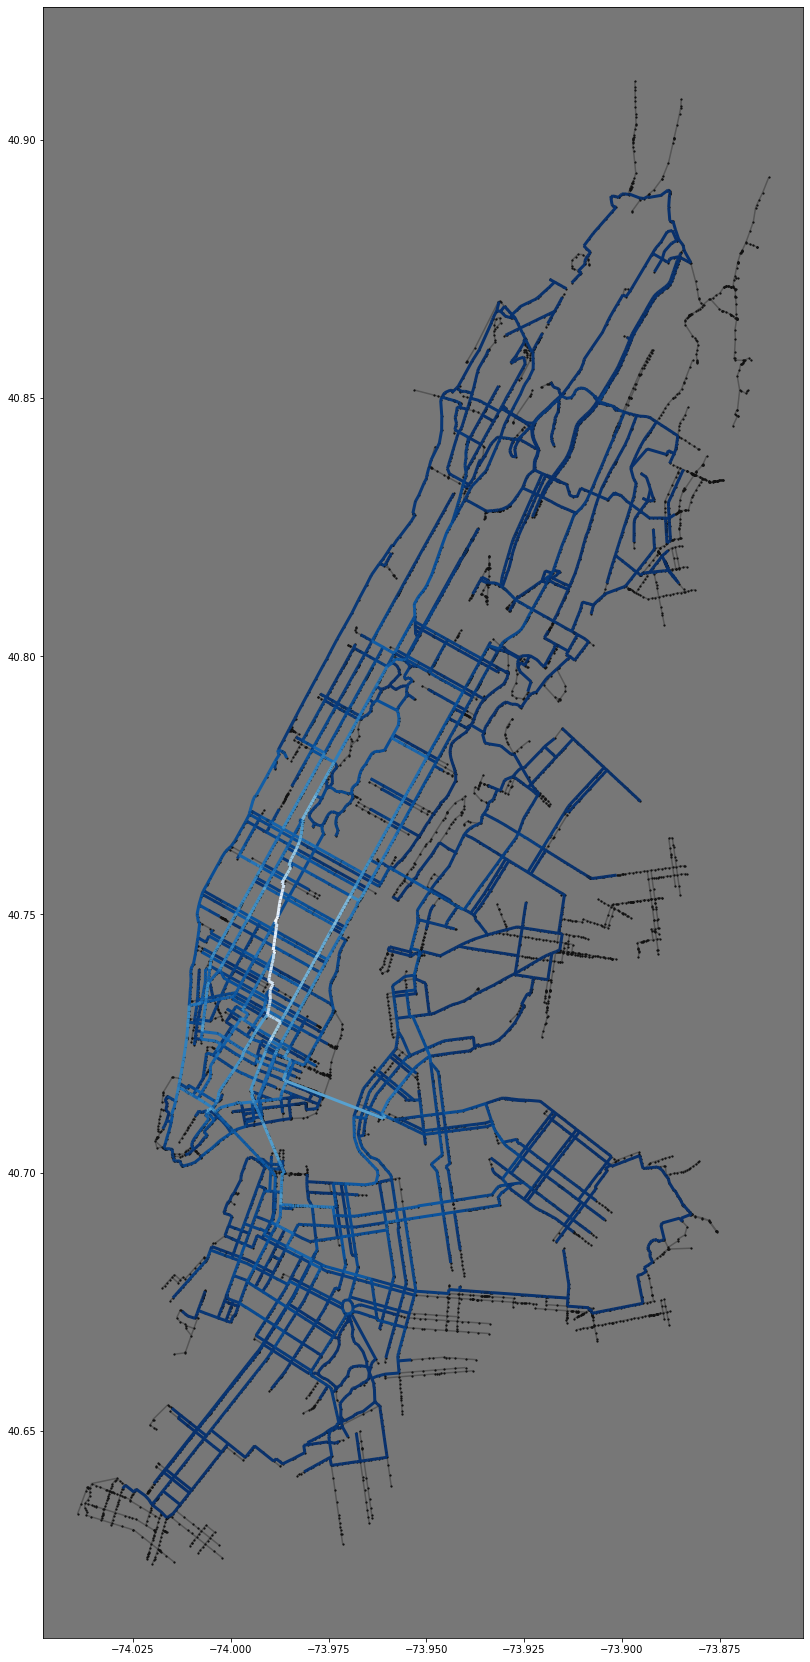

In [53]:
fig, ax = plt.subplots(figsize=(30, 30))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=1.5, color='#111', zorder=2)
edge_count_gdf.sort_values(by=['count']).plot(ax=ax, cmap='Blues_r', column='count', zorder=3, linewidth=3)
ax.set_facecolor('#777')

In [54]:
edge_count_df = pd.DataFrame(edge_count_gdf[['count']])
edge_count_df.to_csv(f'{DATA_DIR}/citibike/exports/edge_counts/{DATE_STRING}_edge_count.csv')